In [ ]:
!pip install boruta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 3.9 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import sklearn.model_selection as skmodel
import sklearn.preprocessing as skprep
import sklearn.metrics as metrics
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from datetime import datetime,date,timedelta
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from boruta import BorutaPy

In [287]:
train_df=pd.read_csv("/content/drive/MyDrive/AIML/Hackathon_Files/Analytics Vidhya/2022-06 Sales Leads/train_wn75k28.csv")

In [288]:
train_df.head()

,id,created_at,campaign_var_1,campaign_var_2,products_purchased,signup_date,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,user_activity_var_5,user_activity_var_6,user_activity_var_7,user_activity_var_8,user_activity_var_9,user_activity_var_10,user_activity_var_11,user_activity_var_12,buy
0,1,2021-01-01,1,2,2.0,2020-09-24,0,0,0,0,0,0,1,1,0,0,0,0,0
1,2,2021-01-01,2,1,2.0,2020-09-19,1,0,1,0,0,0,1,0,0,0,0,0,0
2,3,2021-01-01,9,3,3.0,2021-08-11,1,0,0,0,0,0,0,0,0,0,0,0,0
3,4,2021-01-01,6,7,2.0,2017-10-04,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,2021-01-01,4,6,NaN,2020-06-08,0,0,0,0,0,0,1,0,0,0,1,0,0


In [289]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39161 entries, 0 to 39160
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    39161 non-null  int64  
 1   created_at            39161 non-null  object 
 2   campaign_var_1        39161 non-null  int64  
 3   campaign_var_2        39161 non-null  int64  
 4   products_purchased    18250 non-null  float64
 5   signup_date           24048 non-null  object 
 6   user_activity_var_1   39161 non-null  int64  
 7   user_activity_var_2   39161 non-null  int64  
 8   user_activity_var_3   39161 non-null  int64  
 9   user_activity_var_4   39161 non-null  int64  
 10  user_activity_var_5   39161 non-null  int64  
 11  user_activity_var_6   39161 non-null  int64  
 12  user_activity_var_7   39161 non-null  int64  
 13  user_activity_var_8   39161 non-null  int64  
 14  user_activity_var_9   39161 non-null  int64  
 15  user_activity_var_1

In [290]:
num_records=train_df.shape[0]
print("% missing signup date"+str(train_df.isna().sum()["signup_date"]/num_records))
print("% missing products purchased"+str(train_df.isna().sum()["products_purchased"]/num_records))

% missing signup date0.38591966497280455
% missing products purchased0.5339751283164372


In [291]:
train_df["signup_date"]=pd.to_datetime(train_df["signup_date"])
train_df["created_at"]=pd.to_datetime(train_df["created_at"])
train_df.set_index("id",inplace=True)

In [292]:
#missing value treatment
#train_df["signup_date"]=train_df.apply(lambda x: x["created_at"] if str(x["signup_date"])=="NaT" else x["signup_date"],axis=1)
max_signup_date=train_df["signup_date"].max()
train_df["signup_date"]=train_df.apply(lambda x: max_signup_date if str(x["signup_date"])=="NaT" else x["signup_date"],axis=1)
train_df["products_purchased"]=train_df["products_purchased"].replace(np.nan,0)


In [293]:
max_signup_date=train_df["signup_date"].max()
train_df["days_since_signup_date"]=(max_signup_date-train_df["signup_date"]).dt.total_seconds()/(60*60*24)
train_df["days_since_signup_date"]=train_df["days_since_signup_date"].replace(np.nan,np.mean(train_df["days_since_signup_date"]))

In [294]:
train_df.describe()

,campaign_var_1,campaign_var_2,products_purchased,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,user_activity_var_5,user_activity_var_6,user_activity_var_7,user_activity_var_8,user_activity_var_9,user_activity_var_10,user_activity_var_11,user_activity_var_12,buy,days_since_signup_date
count,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000
mean,6.523812,6.452746,1.003881,0.400092,0.006716,0.102832,0.011465,0.151503,0.499834,0.286612,0.174434,0.011440,0.000383,0.218942,0.000562,0.051020,332.897806
std,3.472944,2.614296,1.199223,0.509194,0.081676,0.303743,0.106463,0.359681,0.558166,0.455784,0.379689,0.106346,0.019568,0.431544,0.023696,0.220042,402.327649
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,176.000000
75%,9.000000,8.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,573.000000
max,16.000000,15.000000,4.000000,3.000000,1.000000,1.000000,1.000000,2.000000,3.000000,2.000000,2.000000,1.000000,1.000000,4.000000,1.000000,1.000000,2608.000000


In [295]:
features_df=train_df.drop(columns=["created_at","signup_date","buy"])
features_df.isna().sum()

campaign_var_1            0
campaign_var_2            0
products_purchased        0
user_activity_var_1       0
user_activity_var_2       0
user_activity_var_3       0
user_activity_var_4       0
user_activity_var_5       0
user_activity_var_6       0
user_activity_var_7       0
user_activity_var_8       0
user_activity_var_9       0
user_activity_var_10      0
user_activity_var_11      0
user_activity_var_12      0
days_since_signup_date    0
dtype: int64

In [296]:
train_df["buy"].value_counts()

0    37163
1     1998
Name: buy, dtype: int64

In [297]:
corr_df=pd.DataFrame(train_df.corr())
low_corr_cols=corr_df[((corr_df["buy"]>-0.10) & (corr_df["buy"]<0.10)) | (corr_df["buy"].isna())].index
high_corr_cols=list(corr_df[(corr_df["buy"]<=-0.05) | (corr_df["buy"]>=0.05)].index)
high_corr_cols.remove("buy")

In [234]:
corr_df["buy"]

campaign_var_1           -0.087202
campaign_var_2           -0.080064
products_purchased        0.005830
user_activity_var_1       0.044811
user_activity_var_2       0.354627
user_activity_var_3       0.005174
user_activity_var_4       0.394706
user_activity_var_5       0.164972
user_activity_var_6      -0.010951
user_activity_var_7      -0.028428
user_activity_var_8      -0.097355
user_activity_var_9       0.463947
user_activity_var_10      0.084423
user_activity_var_11      0.267995
user_activity_var_12      0.067967
buy                       1.000000
days_since_signup_date    0.188907
Name: buy, dtype: float64

In [274]:
#removing the campaign_var_2 multi-colinearity is there with campaign_var_1
high_corr_cols_final=np.delete(high_corr_cols,1)
high_corr_cols_final

array(['campaign_var_1', 'user_activity_var_2', 'user_activity_var_4',
       'user_activity_var_5', 'user_activity_var_8',
       'user_activity_var_9', 'user_activity_var_10',
       'user_activity_var_11', 'user_activity_var_12',
       'days_since_signup_date'], dtype='<U22')

In [188]:
for col in corr_df.columns:
  print(corr_df[corr_df[col]>0.5][col])

campaign_var_1    1.000000
campaign_var_2    0.561489
Name: campaign_var_1, dtype: float64
campaign_var_1    0.561489
campaign_var_2    1.000000
Name: campaign_var_2, dtype: float64
products_purchased    1.0
Name: products_purchased, dtype: float64
user_activity_var_1    1.0
Name: user_activity_var_1, dtype: float64
user_activity_var_2    1.0
Name: user_activity_var_2, dtype: float64
user_activity_var_3    1.0
Name: user_activity_var_3, dtype: float64
user_activity_var_4    1.0
Name: user_activity_var_4, dtype: float64
user_activity_var_5    1.0
Name: user_activity_var_5, dtype: float64
user_activity_var_6    1.0
Name: user_activity_var_6, dtype: float64
user_activity_var_7    1.0
Name: user_activity_var_7, dtype: float64
user_activity_var_8    1.0
Name: user_activity_var_8, dtype: float64
user_activity_var_9    1.0
Name: user_activity_var_9, dtype: float64
user_activity_var_10    1.0
Name: user_activity_var_10, dtype: float64
user_activity_var_11    1.0
Name: user_activity_var_11, dty

In [275]:
X,y=features_df,train_df["buy"]
X_train,X_test,y_train,y_test=skmodel.train_test_split(X,y,test_size=0.3,random_state=100)

In [181]:
# instantiate random forest
forest = RandomForestRegressor(n_jobs = -1, max_depth = 5)

# fit boruta
boruta_selector = BorutaPy(forest, n_estimators = 'auto', random_state = 0)
boruta_selector.fit(np.array(X_train), np.array(y_train))

# store results
boruta_ranking = boruta_selector.ranking_


In [182]:
boruta_ranking

array([1, 2, 3, 4, 1, 7, 1, 1, 5, 5, 1, 1, 8, 1, 9])

In [205]:
selected_features = np.array(features_df.columns)[boruta_ranking <= 4]

In [206]:
#removing the campaign_var_2 multi-colinearity is there with campaign_var_1
selected_features_final=np.delete(selected_features,1)
selected_features_final

array(['campaign_var_1', 'products_purchased', 'user_activity_var_1',
       'user_activity_var_2', 'user_activity_var_4',
       'user_activity_var_5', 'user_activity_var_8',
       'user_activity_var_9', 'user_activity_var_11'], dtype=object)

campaign_var_1 with Class 0


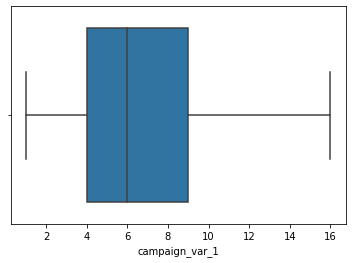

campaign_var_1 with Class 1


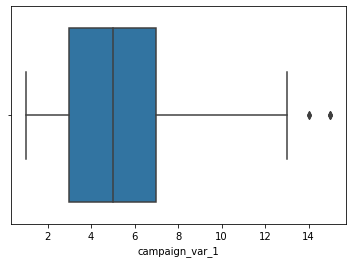

products_purchased with Class 0


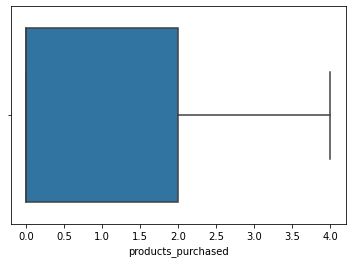

products_purchased with Class 1


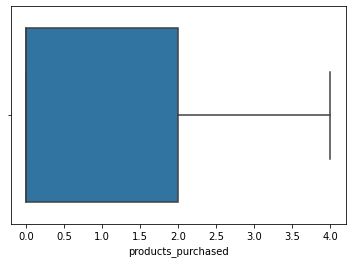

In [207]:
for col in ['campaign_var_1', 'products_purchased']:
    for i in range(2):
        print (col+" with Class "+str(i))
        sns.boxplot(x=col,data=train_df[train_df["buy"]==i])
        plt.show()

In [162]:
train_df_copy=train_df.copy(deep=True)

In [163]:
for col in ['campaign_var_1', 'campaign_var_2', 'products_purchased']:
    Q1=train_df_copy[col].quantile(q=0.25)
    Q3=train_df_copy[col].quantile(q=0.75)
    IQR=Q3-Q1
    print("\n"+col)
    print("Inter-quartile Range (IQR): "+str(IQR))
    lowerWhisker=Q1-1.5*IQR
    upperWhisker=Q3+1.5*IQR
    print("Lower Whisker: "+str(lowerWhisker))
    print("Upper Whisker: "+str(upperWhisker))
    outliers=[i for i in train_df_copy[col] if (i<lowerWhisker or i>upperWhisker)]
    print("Before removing outliers, the mean of "+col+": "+str(np.mean(train_df_copy[col])))
    print("Outliers: "+str(len(outliers)))
    if (len(outliers)>0 & len(outliers)<=1000):
        train_df_copy=(train_df_copy[(train_df_copy[col]>=lowerWhisker) & (train_df_copy[col]<=upperWhisker)])

    print("After removing outliers, the mean of "+col+": "+str(np.mean(train_df_copy[col])))


campaign_var_1
Inter-quartile Range (IQR): 5.0
Lower Whisker: -3.5
Upper Whisker: 16.5
Before removing outliers, the mean of campaign_var_1: 6.523811955772325
Outliers: 0
After removing outliers, the mean of campaign_var_1: 6.523811955772325

campaign_var_2
Inter-quartile Range (IQR): 3.0
Lower Whisker: 0.5
Upper Whisker: 12.5
Before removing outliers, the mean of campaign_var_2: 6.452746354791757
Outliers: 526
After removing outliers, the mean of campaign_var_2: 6.3584573573184935

products_purchased
Inter-quartile Range (IQR): 2.0
Lower Whisker: -3.0
Upper Whisker: 5.0
Before removing outliers, the mean of products_purchased: 1.0069884819464217
Outliers: 0
After removing outliers, the mean of products_purchased: 1.0069884819464217


In [164]:
train_df_copy.shape

(38635, 18)

In [298]:
X,y=train_df[high_corr_cols],train_df["buy"]
X_train,X_test,y_train,y_test=skmodel.train_test_split(X,y,test_size=0.3,random_state=100)

In [ ]:
smt=SMOTE()
X_train,y_train=smt.fit_resample(X_train,y_train)

In [299]:
pca=PCA(n_components=9)
X_train_pca=pca.fit_transform(X_train)
X_test_pca=pca.transform(X_test)
X_pca=pca.fit_transform(X)

In [253]:
y_train.value_counts(normalize=True)

0    0.947249
1    0.052751
Name: buy, dtype: float64

In [ ]:
rf=RandomForestClassifier(random_state=100,n_estimators=1000,max_depth=10)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
print(metrics.classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     11444
           1       0.53      0.95      0.68       305

    accuracy                           0.98     11749
   macro avg       0.76      0.96      0.83     11749
weighted avg       0.99      0.98      0.98     11749



In [ ]:
rf.fit(X_pca,y)
X_test_pca=pca.transform(X_test)
y_pred=rf.predict(X_test_pca)
print(metrics.classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     11422
           1       0.59      0.99      0.73       327

    accuracy                           0.98     11749
   macro avg       0.79      0.98      0.86     11749
weighted avg       0.99      0.98      0.98     11749



In [ ]:
ada=AdaBoostClassifier(n_estimators=1000,learning_rate=0.1,random_state=100)
ada.fit(X_train_pca,y_train)
y_pred=ada.predict(X_test_pca)
print(metrics.classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     11430
           1       0.54      0.93      0.68       319

    accuracy                           0.98     11749
   macro avg       0.77      0.95      0.83     11749
weighted avg       0.99      0.98      0.98     11749



In [ ]:
ada.fit(X_pca,y)
X_test_pca=pca.transform(X_test)
y_pred=ada.predict(X_test_pca)
print(metrics.classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     11434
           1       0.54      0.95      0.69       315

    accuracy                           0.98     11749
   macro avg       0.77      0.96      0.84     11749
weighted avg       0.99      0.98      0.98     11749



In [300]:
xgb=XGBClassifier(random_state=2,learning_rate =0.1, n_estimators=1000, max_depth=15,seed=27)
xgb.fit(X_train_pca,y_train)
y_pred=xgb.predict(X_test_pca)
print(metrics.classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     11329
           1       0.57      0.75      0.65       420

    accuracy                           0.97     11749
   macro avg       0.78      0.87      0.82     11749
weighted avg       0.98      0.97      0.97     11749



In [301]:
xgb.fit(X_pca,y)
y_pred=xgb.predict(X_test_pca)
print(metrics.classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     11359
           1       0.64      0.91      0.75       390

    accuracy                           0.98     11749
   macro avg       0.82      0.95      0.87     11749
weighted avg       0.98      0.98      0.98     11749



In [306]:
test_df=pd.read_csv("/content/drive/MyDrive/AIML/Hackathon_Files/Analytics Vidhya/2022-06 Sales Leads/test_Wf7sxXF.csv")
test_df.isna().sum()

id                         0
created_at                 0
campaign_var_1             0
campaign_var_2             0
products_purchased      8136
signup_date             6649
user_activity_var_1        0
user_activity_var_2        0
user_activity_var_3        0
user_activity_var_4        0
user_activity_var_5        0
user_activity_var_6        0
user_activity_var_7        0
user_activity_var_8        0
user_activity_var_9        0
user_activity_var_10       0
user_activity_var_11       0
user_activity_var_12       0
dtype: int64

In [307]:
test_df.set_index("id",inplace=True)
test_df["signup_date"]=pd.to_datetime(test_df["signup_date"])
test_df["created_at"]=pd.to_datetime(test_df["created_at"])
max_signup_date=train_df["signup_date"].max()
#test_df["signup_date"]=test_df.apply(lambda x: x["created_at"] if str(x["signup_date"])=="NaT" else x["signup_date"],axis=1)
test_df["signup_date"]=test_df.apply(lambda x: max_signup_date if str(x["signup_date"])=="NaT" else x["signup_date"],axis=1)
test_df["products_purchased"]=test_df["products_purchased"].replace(np.nan,0)
max_signup_date=test_df["signup_date"].max()
test_df["days_since_signup_date"]=(max_signup_date-test_df["signup_date"]).dt.total_seconds()/(60*60*24)
test_df["days_since_signup_date"]=test_df["days_since_signup_date"].replace(np.nan,np.mean(test_df["days_since_signup_date"]))

In [308]:
X_val=test_df[high_corr_cols]
X_val_pca=pca.transform(X_val)
y_val_pred=xgb.predict(X_val_pca)

In [309]:
y_val_pred_series=pd.Series(y_val_pred)
sales_lead_val_id_series=test_df.reset_index()["id"]
output_df=pd.DataFrame({"buy":y_val_pred_series})
output_df.index=sales_lead_val_id_series
output_df.index.name="id"

In [310]:
y_val_pred_series.value_counts()

0    12788
1      396
dtype: int64

In [311]:
output_df.sort_values(by="id").to_csv("/content/drive/MyDrive/AIML/Hackathon_Files/Analytics Vidhya/2022-06 Sales Leads/submission_2022-06-05_1535.csv")